<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/saliencymap_making_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

顕著性マップをpytorchで作ってみようのコードです．

まずはimport

In [ ]:
import torch
!pip install torchinfo
from torchinfo import summary
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

torchのversionを確認します．

1.6.0だとtorch.fft.fft2が利用できませんでした．

In [ ]:
print(torch.__version__)

1.9.0+cu102


今回のサンプル画像はlenaです．

lenaをダウンロードするコードを書き加えてくれた方ありがとうございます．

--2021-08-05 04:29:21--  http://optipng.sourceforge.net/pngtech/img/lena.png
Resolving optipng.sourceforge.net (optipng.sourceforge.net)... 204.68.111.100
Connecting to optipng.sourceforge.net (optipng.sourceforge.net)|204.68.111.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 462.73K  --.-KB/s    in 0.08s   

2021-08-05 04:29:21 (5.99 MB/s) - ‘lena.png’ saved [473831/473831]

lena.png  sample_data
torch.Size([3, 512, 512])


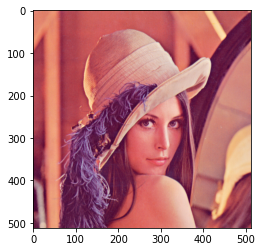

In [ ]:
!wget -nc http://optipng.sourceforge.net/pngtech/img/lena.png
!ls
lena = Image.open("lena.png")
lena = lena.convert('RGB')
lena = np.array(lena)
lena = torch.from_numpy(lena).permute(2,0,1)
print(lena.shape)  # (512, 512)
plt.imshow(lena.permute(1,2,0),cmap='gray')

顕著性マップはgrayscaleで作るっぽいので，RGB→grayの変換用畳み込み層を定義しています．



In [ ]:
# RGB -> grayscale変換するone by one2次元畳み込みフィルタを定義しています．
rgb2gray = torch.nn.Conv2d(3,1,1,padding=0, bias=False)
rgb2gray.weight = torch.nn.Parameter(torch.tensor([0.2989, 0.5870, 0.1140]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1))

一旦彌榮さんが作っていたコードで動くか確認します．(比較用ともいう)

アルゴリズムの原著論文はこちら↓

IEEE(買われてないから読めない):https://ieeexplore.ieee.org/abstract/document/4270292

論文:http://www.houxiaodi.com/assets/papers/cvpr07.pdf

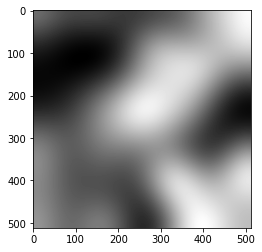

In [ ]:
# making saliency map with scipy (Mie made this code)
# 彌榮さん作成の関数で顕著性マップを作成してみる．
import numpy as np
import os
import pathlib
from PIL import Image
from scipy.ndimage import gaussian_filter
from scipy.fftpack import next_fast_len, fft2, ifft2, fftshift, ifftshift
def ComputeSaliencyMap(inImage):
    inImage_size = (inImage.shape[1], inImage.shape[0])  # (width, height)
    # resize  画像の中で目立つ領域を発見するため，計算量削減のために小さくする．そのまま顕著性マップを求めると細かすぎる．
    scale = 0.05
    resize_size = (int(inImage_size[0] * scale), int(inImage_size[1] * scale))
    inImage = np.array(Image.fromarray(inImage).resize(resize_size))  # ndarrayをPIL.Imageに変換，resize

    # (高速)フーリエ変換[FFT]
    # give the value from next_fast_len to fft2, then automatically zero paded to the size.
    # fft2にnext_fast_lenで求めた値を渡すと，自動的にそのサイズにzero paddingされる．
    FT_inImage = fft2(inImage)
    FT_inImage = fftshift(FT_inImage)  # ゼロ周波数成分をスペクトルの中心にシフトする．
    # 対数スペクトル，振幅[Amplitude]
    Amp = np.log(abs(FT_inImage))
    # 位相スペクトル[Phase Spectra]
    Phase = np.angle(FT_inImage)

    # gaussian filter(don't blur that much here)
    # 対数スペクトルAmpにガウシアンフィルタを適用した関数L．(ここではあまりぼかさない)
    L_Amp = gaussian_filter(Amp, sigma=0.001)
    # フィルタ適用前と適用後の差分R
    R_Amp = L_Amp - Amp
    
    # Rを(高速)逆フーリエ変換[IFFT]し，顕著性マップSを作る．
    R_complex = np.exp(R_Amp + Phase*1j)
    R_complex = ifftshift(R_complex)  # fftshiftの逆．
    saliencyMap = ifft2(R_complex)
    saliencyMap = abs(saliencyMap)
    
    # gaussian filter(blur)
    # 後処理．ガウシアンフィルタを適用．ぼかす．
    saliencyMap = gaussian_filter(saliencyMap, sigma=2.5)
    # resize to original size  元の大きさに拡大．
    saliencyMap = np.array(Image.fromarray(saliencyMap[0:resize_size[1], 0:resize_size[0]]).resize(inImage_size))
    # normalize values from 0 to 255
    # 0~255の整数値に正規化．
    saliencyMap = ((saliencyMap - np.min(saliencyMap)) * 255 / (np.max(saliencyMap) - np.min(saliencyMap))).astype(np.uint8)
    return saliencyMap

img = lena.unsqueeze(0).float()
img = rgb2gray(img)
sc = ComputeSaliencyMap(img[0,0].detach().int().numpy())
plt.imshow(sc, cmap='gray')
salmap_scipy = sc

ここまでnumpy(一部torch入ってたけど)

---------------------------------------
ここからtorch

顕著性マップを作る際に利用するfftとifftを試してみます．

Text(0.5, 1.0, 'input -> fft -> ifft -> result')

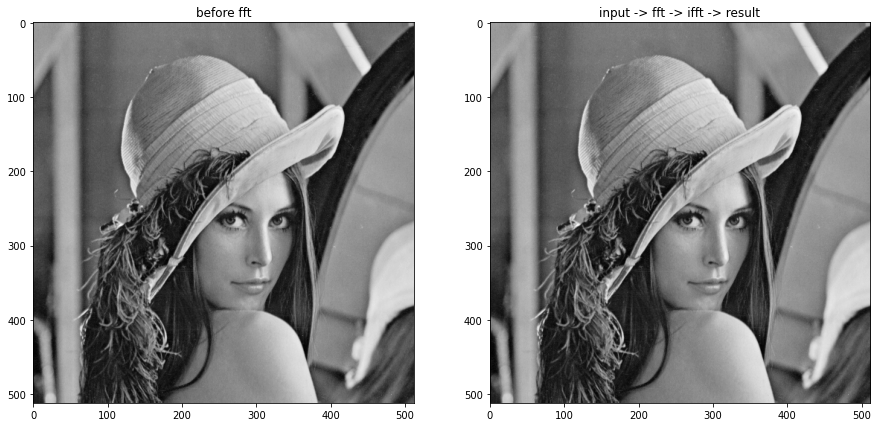

In [ ]:
import torch.fft
import torch
from PIL import Image
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
img = lena.unsqueeze(0).float()
img = rgb2gray(img)
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img[0,0].detach(),cmap='gray')
plt.title('before fft')
fft_img = torch.fft.fft2(img)
ifft_img = torch.fft.ifft2(fft_img)
ifft_img = ifft_img.to('cpu').detach().numpy().copy()
ifft_img = ifft_img.real.astype(np.int)
plt.subplot(1,2,2)
plt.imshow(ifft_img[0,0], cmap = "gray")
plt.title('input -> fft -> ifft -> result')

再構成できました．

彌榮さんのコードを参考に，顕著性マップ作成をpytrochに移植したものがこちら

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


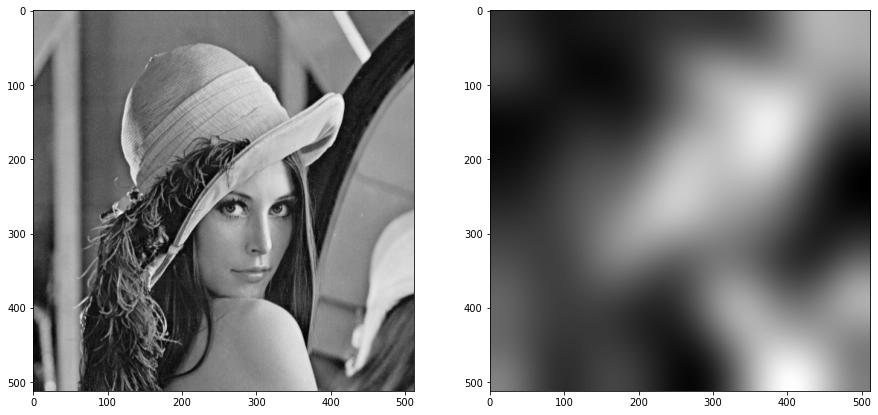

In [ ]:
# making saliency map with pytorch
# 彌榮さんのコードを参考に，pytorchに移植してみました．
def gausian(kernel_size, sigma):
    l = torch.nn.Conv2d(1,1,kernel_size,bias=False, groups=1, padding=int(kernel_size/2), padding_mode='reflect')
    w = torch.zeros(kernel_size**2).reshape(kernel_size,kernel_size)
    for i in range(int(-kernel_size/2),int(+kernel_size/2)+1):
        for j in range(int(-kernel_size/2),int(+kernel_size/2)+1):
            w[i+int(kernel_size/2),j+int(kernel_size/2)] = torch.exp(torch.tensor(-(i**2+j**2)/(2*sigma**2)))/(2*np.pi*sigma**2)
    w = w/w.sum()
    l.weight = torch.nn.Parameter(torch.tensor(w).unsqueeze(0).unsqueeze(0))
    return l
l = gausian(5,0.001)

l2 = gausian(25,2.5)
pool = torch.nn.Sequential(torch.nn.AvgPool2d(2),
                           torch.nn.AvgPool2d(2),
                           torch.nn.AvgPool2d(2),
                           torch.nn.AvgPool2d(2),
)
up = torch.nn.Sequential(
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Upsample(scale_factor=2, mode='bilinear'),
)


img = lena.unsqueeze(0).float()
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
img = rgb2gray(img)
plt.imshow(img[0,0].cpu().detach(),cmap='gray')
img = pool(img)
fft_img = torch.fft.fft2(img)
fft_img = torch.fft.fftshift(fft_img)

A = torch.log(abs(fft_img))
P = torch.angle(fft_img)

L_amp = l(A)
R_amp = L_amp - A

R_comp = torch.exp(R_amp + P*1j)
R_comp = torch.fft.ifftshift(R_comp)
R_comp = torch.fft.ifft2(R_comp)
sailencymap = abs(R_comp)

sailencymap = l2(sailencymap)
sailencymap = up(sailencymap)
s = sailencymap.detach()[0][0]
s = s/s.max()*255
plt.subplot(1,2,2)
plt.imshow(s,cmap='gray')
salmap_torch = s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


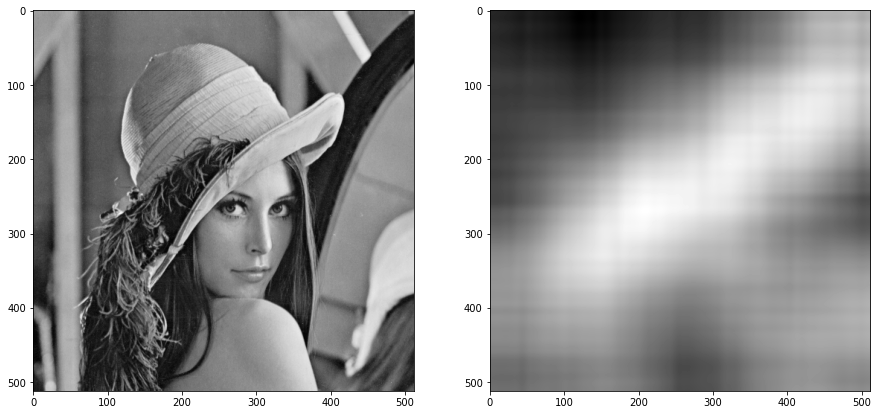

In [ ]:
#@title 原著論文と同じパラメータで試したもの．特に変わらないので気にしないでください．
# lとかl2のsigmaとかが変わってます．
# input(512,512) -> image(64,64) -> calc
def gausian(kernel_size, sigma):
    l = torch.nn.Conv2d(1,1,kernel_size,bias=False, groups=1, padding=int(kernel_size/2), padding_mode='reflect')
    w = torch.zeros(kernel_size**2).reshape(kernel_size,kernel_size)
    for i in range(int(-kernel_size/2),int(+kernel_size/2)+1):
        for j in range(int(-kernel_size/2),int(+kernel_size/2)+1):
            w[i+int(kernel_size/2),j+int(kernel_size/2)] = torch.exp(torch.tensor(-(i**2+j**2)/(2*sigma**2)))/(2*np.pi*sigma**2)
    w = w/w.sum()
    l.weight = torch.nn.Parameter(torch.tensor(w).unsqueeze(0).unsqueeze(0))
    return l
l = torch.nn.Conv2d(1,1,3, bias=False, padding=1)
l.weight = torch.nn.Parameter(torch.ones(l.weight.shape) / 9)

l2 = gausian(25,8)
pool = torch.nn.Sequential(torch.nn.AvgPool2d(2),
                           torch.nn.AvgPool2d(2),
                           torch.nn.AvgPool2d(2),
)
up = torch.nn.Sequential(
    nn.Upsample(scale_factor=2, mode='bicubic'),
    nn.Upsample(scale_factor=2, mode='bicubic'),
    nn.Upsample(scale_factor=2, mode='bicubic'),
)

img = lena.unsqueeze(0).float()
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
img = rgb2gray(img)
plt.imshow(img[0,0].cpu().detach(),cmap='gray')
img = pool(img)
fft_img = torch.fft.fft2(img)
fft_img = torch.fft.fftshift(fft_img)

A = torch.log(abs(fft_img))
P = torch.angle(fft_img)

L_amp = l(A)
R_amp = A - L_amp

R_comp = torch.exp(R_amp + P*1j)
R_comp = torch.fft.ifftshift(R_comp)
R_comp = torch.fft.ifft2(R_comp)
sailencymap = abs(R_comp)

sailencymap = l2(sailencymap)
sailencymap = up(sailencymap)
s = sailencymap.detach()[0][0]
s = s/s.max()*255
plt.subplot(1,2,2)
plt.imshow(s,cmap='gray')

全部pytrochのコードで書けたので，モデル構造にしておきます．

モデル化した際，出力に変化がないか確認……

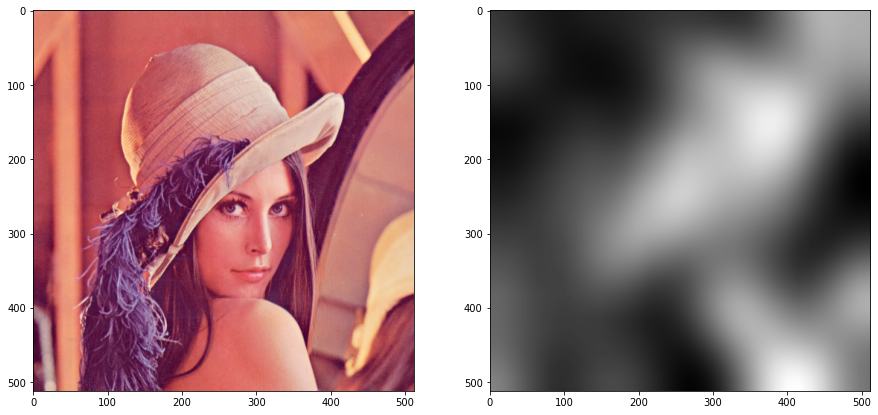

In [ ]:
# making saliency map with pytorch end-to-end model
# 全部バックプロップ可能だったので，モデル構造に落とし込みます．
class saliencymap_model(torch.nn.Module):
    def __init__(self, sigma1, sigma2, iterpool, kernel_size1, kernel_size2):
        super().__init__()
        pool = []
        for i in range(iterpool):
            pool.append(torch.nn.AvgPool2d(2))
        up = []
        for i in range(iterpool):
            up.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True)) # align_corners=True こうしないと延々warningが出ます．
        self.pool = torch.nn.Sequential(*pool)
        self.up = torch.nn.Sequential(*up)
        self.rgb2gray = torch.nn.Conv2d(3,1,1,padding=0, bias=False)
        self.rgb2gray.weight = torch.nn.Parameter(torch.tensor([0.2989, 0.5870, 0.1140]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1))
        self.layer1 = self._gause(kernel_size1, sigma1)
        self.layer2 = self._gause(kernel_size2, sigma2)
    def forward(self, x):
        x = self.pool(x)
        x = self.rgb2gray(x)

        x = torch.fft.fft2(x)
        x = torch.fft.fftshift(x)
        
        A = torch.log(abs(x))
        P = torch.angle(x)

        L_amp = self.layer1(A)
        R_amp = L_amp - A
        
        R_comp = torch.exp(R_amp + P*1j)
        R_comp = torch.fft.ifftshift(R_comp)
        R_comp = torch.fft.ifft2(R_comp)
        sailencymap = abs(R_comp)
        
        sailencymap = self.layer2(sailencymap)
        sailencymap = self.up(sailencymap)

        return sailencymap
    def _gause(self, kernel_size, sigma):
        l = torch.nn.Conv2d(1,1,kernel_size,bias=False, groups=1, padding=int(kernel_size/2), padding_mode='reflect')
        w = torch.zeros(kernel_size**2).reshape(kernel_size,kernel_size)
        for i in range(int(-kernel_size/2),int(+kernel_size/2)+1):
            for j in range(int(-kernel_size/2),int(+kernel_size/2)+1):
                w[i+int(kernel_size/2),j+int(kernel_size/2)] = torch.exp(torch.tensor(-(i**2+j**2)/(2*sigma**2)))/(2*np.pi*sigma**2)
        w = w/w.sum()
        l.weight = torch.nn.Parameter(w.unsqueeze(0).unsqueeze(0))
        return l

img = lena.unsqueeze(0).float().clone()
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(lena.permute(1,2,0))
model = saliencymap_model(0.001, 2.5, 4, 5, 11)
sample = model(img)
s = sample.detach()[0][0]
s = s/s.max()*255
plt.subplot(1,2,2)
plt.imshow(s.cpu().detach(),cmap='gray')
salmap_model = s

Text(0.5, 1.0, 'torch model')

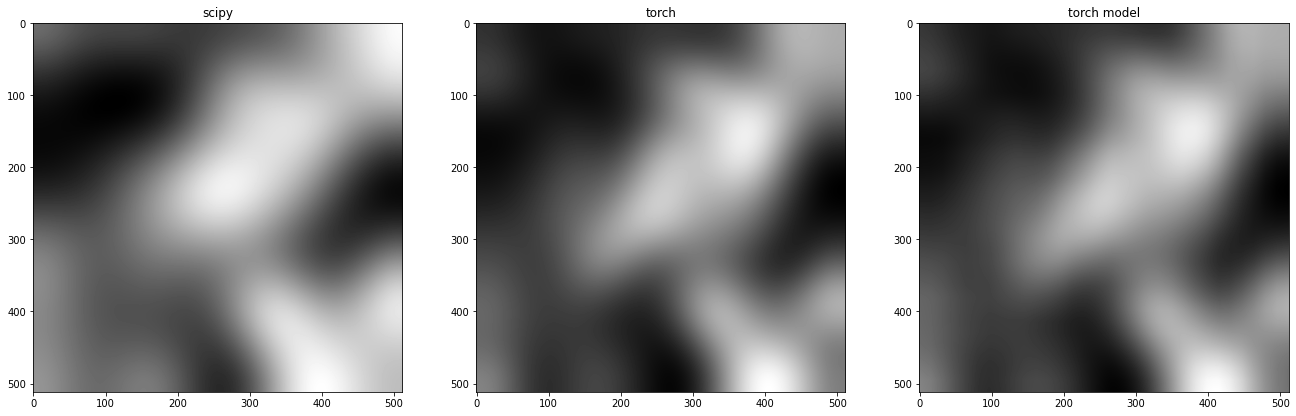

In [ ]:
fig = plt.figure(figsize = (22.5,15))
plt.subplot(1,3,1)
plt.imshow(salmap_scipy, cmap='gray')
plt.title('scipy')
plt.subplot(1,3,2)
plt.imshow(salmap_torch, cmap='gray')
plt.title('torch')
plt.subplot(1,3,3)
plt.imshow(salmap_model, cmap='gray')
plt.title('torch model')

ひとつのmoduleに落とし込めたので，他のモデルの一部にすることができるようになりました．

と言うわけで彌榮さんのモデルに組み込んでみました．

画像サイズは細胞診において(1024, 1280)です．縮小して入力するなら，それなりな値を入れて下さい．

実験してみると，input_size = (batch_size, channel, x, y) = (16, 3, 256, 320) で大体13GBくらいメモリを食いました．

In [ ]:
# MIe's model with trainable algolithm (sailency map)
# 彌榮さんのモデルに先ほどの学習可能となった顕著性マップ作成アルゴリズムを内包させてみています．
class mymodel(torch.nn.Module):
    def __init__(self, sigma1, sigma2, iterpool, kernel_size1, kernel_size2):
        super().__init__()
        self.saliency = saliencymap_model(sigma1, sigma2, iterpool, kernel_size1, kernel_size2)
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(4,64,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64,128,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,2,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(2),
            torch.nn.MaxPool2d(2),
        )
    def forward(self, x):
        saliencymap = self.saliency(x)
        x = torch.cat((x, saliencymap), 1)
        x = self.conv(x)
        pred = x.mean([2,3])
        return pred, x
m = mymodel(0.001, 2.5, 4, 5, 11)
# input_size = (batch_size, channnel, x, y)
# 今回はbatch_size=8を想定．画像サイズは元の画像サイズのまま入力した時を想定しています．
# CPU計算だとさすがに時間がかかったりします．
# さすがに元画像のままだと厳しいようです．
summary(m,input_size=(32, 3, 256, 320))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
mymodel                                  --                        --
├─sailencymap_model: 1-1                 [32, 1, 256, 320]         --
│    └─Sequential: 2-1                   [32, 3, 16, 20]           --
│    │    └─AvgPool2d: 3-1               [32, 3, 128, 160]         --
│    │    └─AvgPool2d: 3-2               [32, 3, 64, 80]           --
│    │    └─AvgPool2d: 3-3               [32, 3, 32, 40]           --
│    │    └─AvgPool2d: 3-4               [32, 3, 16, 20]           --
│    └─Conv2d: 2-2                       [32, 1, 16, 20]           3
│    └─Conv2d: 2-3                       [32, 1, 16, 20]           25
│    └─Conv2d: 2-4                       [32, 1, 16, 20]           121
│    └─Sequential: 2-5                   [32, 1, 256, 320]         --
│    │    └─Upsample: 3-5                [32, 1, 32, 40]           --
│    │    └─Upsample: 3-6                [32, 1, 64, 80]           --
│    │    └─Ups

attention branchにも入れてみたやつ．

未実験です．
多分めっちゃメモリ食います．

In [ ]:
# Matsuo's model with trainable algolithm (sailency map)
class mymodel(torch.nn.Module):
    def __init__(self, sigma1, sigma2, iterpool, kernel_size1, kernel_size2):
        super().__init__()
        self.saliency = saliencymap_model(sigma1, sigma2, iterpool, kernel_size1, kernel_size2)
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(3,64,3,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64,128,3,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(128,2,3,padding=1),
            torch.nn.BatchNorm2d(2),
            torch.nn.MaxPool2d(2),
        )
        self.attention_branch_pre = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.attention_branch_pre_feature = torch.nn.Sequential(
            torch.nn.Conv2d(128,16,3,padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
        )
        self.attention_branch = torch.nn.Sequential(
            torch.nn.Conv2d(32,16,3,padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16,4,3,padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4,2,3,padding=1),
            torch.nn.BatchNorm2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2,1,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
    def forward(self, x):
        saliencymap = self.saliency(x)
        x = self.conv(x)
        attn = self.attention_branch_pre(saliencymap)
        feature = self.attention_branch_pre_feature(x)
        attn = torch.cat((attn,feature),1)
        x = self.conv2(x)
        attn = self.attention_branch(attn)
        attn = attn+1
        x = x * attn
        pred = x.mean([2,3])
        return pred, x
m = mymodel(0.001, 2.5, 4, 5, 11)
# input_size = (batch_size, channnel, x, y)
summary(m,input_size=(32, 3, 256, 320))

Layer (type:depth-idx)                   Output Shape              Param #
mymodel                                  --                        --
├─sailencymap_model: 1-1                 [32, 1, 256, 320]         --
│    └─Sequential: 2-1                   [32, 3, 16, 20]           --
│    │    └─AvgPool2d: 3-1               [32, 3, 128, 160]         --
│    │    └─AvgPool2d: 3-2               [32, 3, 64, 80]           --
│    │    └─AvgPool2d: 3-3               [32, 3, 32, 40]           --
│    │    └─AvgPool2d: 3-4               [32, 3, 16, 20]           --
│    └─Conv2d: 2-2                       [32, 1, 16, 20]           3
│    └─Conv2d: 2-3                       [32, 1, 16, 20]           25
│    └─Conv2d: 2-4                       [32, 1, 16, 20]           121
│    └─Sequential: 2-5                   [32, 1, 256, 320]         --
│    │    └─Upsample: 3-5                [32, 1, 32, 40]           --
│    │    └─Upsample: 3-6                [32, 1, 64, 80]           --
│    │    └─Ups